# Modelling the eclipse profile of PSR J0737-3039A by the magnetosphere of PSR J0737-3039B


Throughout this notebook we will follow the pedagogy of Lyutikov & Thompson (2005), whom developed the original dipole B-field model for describing the Double Pulsar eclipses.

In [1]:
import numpy as np
from scipy.integrate import simps
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Lyutikov & Thompson (2005) define a Cartesian coordinate system in which they model the eclipses of A by B. In this system, Pulsar B is placed at the origin where x is the line-of-sight plane from the pulsar to Earth, y lies along the projected oribtal direction of Pulsar A, and z is orthogonal to the x-y plane (normal to the orbital plane of the binary). In this system the apparent motion of Pulsar A around B occurs at a fixed value of $z = z_{0}$.

We start by converting the oribtal phase to units of y (cm) as
$$y(t) = \frac{\pi a}{2} \Big[ 1 - \Big( \frac{\phi_{\mathrm{orb}}}{90^{\circ}} \Big) \Big],$$
where $a$ is the semi-major axis in cm and $\phi_{\mathrm{orb}}$ is the orbital phase in degrees. Note: $\phi_{\mathrm{orb}} = 0^{\circ}$ corresponds to the eclipse centre.

In [2]:
def get_y_from_orbital_phase(semi_major_axis, phi_orb):
    """
    Returns the y-coordinates corresponding to the input orbital phase.
    Parameters
    ----------
    semi_major_axis: scalar-like
        Semi-major axis (cm)
    phi_orb: array-like
        Orbital phase (deg)
    """
    return ((np.pi * semi_major_axis)/2) * (1 - (phi_orb/(90 * u.deg)))

From here, we can calculate the radial distance of any given point to Pulsar B as
$$ r(x, t) = \sqrt{x^{2} + y^{2}(t) + z_{0}^{2}}. $$

In [3]:
def radial_distance(x, y, z_0):
    """
    Distance from a given point to pulsar B.
    Parameters
    ----------
    x: array-like
        x-coordinate (cm)
    y: array-like
        y-coordinate (cm)
    z_0: array-like
        z-coordinate (cm)
    """
    return np.sqrt(x**2 + y**2 + z_0**2)

The transform between the co-latitude and longitude of the spin axis from a coordinate system aligned with the total anglula mometum vector ($\delta$, $\phi_{\mathrm{so}}$) to Cartesian coordinates ($\theta$, $\phi$) is given by
$$ \cos(\theta) = \cos(90^{\circ} - i)\cos(\delta) - \sin(90 - i)\sin(\delta)\cos(\phi_{\mathrm{so}}), $$
$$ \sin(\phi) = \frac{\sin(\delta)\sin(\phi_{\mathrm{so}})}{\sin(\theta)}, $$
where $i$ is the orbital inclination from the observer's perspective.

In [4]:
def get_cos_theta(i, delta, phi_SO):
    """
    Colatitude of Pulsar B's spin axis w.r.t the z-axis
    Parameters
    ----------
    i: scalar-like
        Orbital inclination (deg)
    delta: scalar-like
        Colatitude of Pulsar B's spin axis w.r.t the total angular 
        momentm vector (deg)
    phi_SO: scalar-like
        Longitude of Pulsar B's spin axis w.r.t. the total angular 
        momentm vector (deg)
    """
    return np.cos((90 * u.deg) - i)*np.cos(delta) - np.sin((90 * u.deg) 
               - i)*np.sin(delta)*np.cos(phi_SO)

In [5]:
def get_sin_phi(delta, phi_SO, theta):
    """
    Longitude of Pulsar B's spin axis w.r.t the z-axis
    Parameters
    ----------
    delta: scalar-like
        Colatitude of Pulsar B's spin axis w.r.t the total angular 
        momentm vector (deg)
    phi_SO: scalar-like
        Longitude of Pulsar B's spin axis w.r.t. the total angular 
        momentm vector (deg)
    theta: scalar-like
        Colatitude of Pulsar B's spin axis w.r.t the z-axis (deg)
    """
    return (np.sin(delta) * np.sin(phi_SO))/np.sin(theta)

The polar angle between the magnetic axis and $\mathbf{r}$ is determined from the unit vector $\hat{\mathbf{\mu}}(t)$ that is parallel to $\mathbf{\mu}_{B}(t)$,
$$ \cos(\theta_{\mu}) =  \frac{\hat{\mathbf{\mu}} \cdot \mathbf{r}}{r}$$.
We can express the components of $\hat{\mathbf{\mu}}$ in a coordinate system that is aligned with the spin axis ($\Omega_{B}$) as
$$ \hat{\mu}^{\Omega}_{x} = \sin(\alpha) \cos(\Omega_{B}t), $$
$$ \hat{\mu}^{\Omega}_{y} = \sin(\alpha) \sin(\Omega_{B}t), $$
$$ \hat{\mu}^{\Omega}_{z} = \cos(\alpha), $$
where $\alpha$ is the angle between the spin and magnetic axes.
Transformed into the observer frame, these components are expressed as
$$ \hat{\mu}_{x} = (\hat{\mu}^{\Omega}_{x}\cos(\theta) + \hat{\mu}^{\Omega}_{z}\sin(\theta))\cos(\phi) - \hat{\mu}^{\Omega}_{y}\sin(\theta), $$
$$ \hat{\mu}_{y} = \hat{\mu}^{\Omega}_{y}\cos(\phi) + (\hat{\mu}^{\Omega}_{x}\cos(\theta) + \hat{\mu}^{\Omega}_{z}\sin(\theta))\sin(\theta), $$
$$ \hat{\mu}_{z} = \hat{\mu}^{\Omega}_{z}\cos(\theta) - \hat{\mu}^{\Omega}_{x}\sin(\theta). $$

In [6]:
def spin_aligned_dipole_unit_vector_components(alpha, time):
    """
    Componentents of the dipole unit vector (mu-hat) aligned with the spin-axis.
    Parameters
    ----------
    alpha: scalar-like
        Angle between the spin and magnetic axes (deg)
    time: array-like
        Times at which the light-curve is being computed (s)
    """
    # Position of the 
    OM_B = (2 * np.pi * u.rad)/(2.77 * u.s)
    
    # Unit vecor components (spin-aligned)
    mu_hat_omega_x = np.sin(alpha) * np.cos(OM_B * time)
    mu_hat_omega_y = np.sin(alpha) * np.sin(OM_B * time)
    mu_hat_omega_z = np.cos(alpha)
    
    return mu_hat_omega_x, mu_hat_omega_y, mu_hat_omega_z

In [7]:
def cartesian_dipole_unit_vector_components(alpha, time, i, delta, phi_SO):
    """
    Componentents of the dipole unit vector (mu-hat) in Cartesian coordinates.
    Parameters
    ----------
    alpha: scalar-like
        Angle between the spin and magnetic axes (deg)
    time: array-like
        Times at which the light-curve is being computed (s)
    i: scalar-like
        Orbital inclination (deg)
    delta: scalar-like
        Colatitude of Pulsar B's spin axis w.r.t the total angular 
        momentm vector (deg)
    phi_SO: scalar-like
        Colongitude of Pulsar B's spin axis w.r.t. the total angular 
        momentm vector (deg)    
    """
    # Colatitude and longitude of Pulsar B's spin axis
    cos_theta = get_cos_theta(i, delta, phi_SO)
    sin_theta = np.sin(np.arccos(cos_theta))
    sin_phi = get_sin_phi(delta, phi_SO, np.arccos(cos_theta))
    cos_phi = np.cos(np.arcsin(sin_phi))
    
    # Unit vecor components (spin-aligned)
    mu_hat_omega = spin_aligned_dipole_unit_vector_components(alpha, time)
    
    # Unit vecor components (Cartesian)
    mu_hat_x = ((mu_hat_omega[0]*cos_theta + mu_hat_omega[2]*sin_theta)
        *cos_phi - mu_hat_omega[1]*sin_phi)
    mu_hat_y = ((mu_hat_omega[0]*cos_theta + mu_hat_omega[2]*sin_theta)
        *sin_phi - mu_hat_omega[1]*cos_phi)
    mu_hat_z = mu_hat_omega[2]*cos_theta - mu_hat_omega[0]*sin_theta
    
    return mu_hat_x, mu_hat_y, mu_hat_z

In [8]:
def cos_magnetic_polar_angle(mu_hat, r_vector, r_scalar):
    """
    Returns the cosine of the magnetic polar angle.
    Parameters
    ----------
    mu_hat: array-like
        Vector of x, y & z components of mu_hat (unitless)
    r_vector: array-like
        Cartesian coordinates (cm)
    r_scalar: array-like
        Radial coordinates from Pulsar B (cm)
    """
    return sum([i*j for (i, j) in zip(mu_hat, r_vector)])/r_scalar

The strength of Pulsar B's magnetic field at position $\mathbf{x}$ is
$$ B = \frac{\sqrt{ 1 + 3\cos^{2}(\theta_{\mu}) }}{r^{3}} \mu_{B}. $$

In [9]:
def dipole_field_strength(cos_theta_mu, r_scalar, mu_B):
    """
    Magnetic field strength along the line of sight.
    Parameters
    ----------
    cos_theta_mu: array-like
        Cosine of the polar angle (unitless)
    r_scalar: array-like
        Radial coordinates from Pulsar B (cm)
    mu_B: scalar?
        Magnitude of the magnetic moment (deg?)
    """
    return mu_B * np.sqrt(1 + 3*(cos_theta_mu**2))/(r_scalar**3)

The angle between the local magnetic field direction and the line-of-sight is given by:
$$ \cos(\kappa) = \frac{B_{x}}{B} = \frac{3\cos(\theta_{\mu})(x/r) - \hat{\mu}_{x}}{\sqrt{1 + 3\cos^{2}(\theta_{\mu})}} $$

In [10]:
def get_sin_kappa(cos_theta_mu, x, r_scalar, mu_hat_x):
    """
    Angle between the local magnetic field direction and the line-of-sight.
    Parameters
    ----------
    cos_theta_mu: array-like
        Cosine of the polar angle (unitless)
    x: array-like
        Values along the line of sight (cm)
    r_scalar: array-like
        Radial coordinates from Pulsar B (cm)
    mu_hat_x: array_like
        Unit vector along in the x-direction (cm)
    """
    
    return ((3*cos_theta_mu*(x/r_scalar)) - mu_hat_x)/np.sqrt(1 + 3*(cos_theta_mu**2))

Combining all of this together, we can derive the optical depth by integrating over the absorption coefficient for $-R_{\mathrm{mag}} < x < +R_{\mathrm{mag}}$ as
$$ \tau = \xi \int^{+R_{\mathrm{mag}}}_{-R_{\mathrm{mag}}} \Big( \frac{B\sin(\kappa)}{B_{\mathrm{mag}}} \Big) d\Big( \frac{x}{R_{\mathrm{mag}}} \Big) ,$$
where $\xi$ is the characteristic optical depth of Pulsar B's magnetosphere.

In [11]:
def get_optical_depth(xi, freq, B_field, B_mag, sin_kappa, x_coords, R_mag):
    """
    Optical depth of Pulsar B's magnetosphere.
    Parameters
    ----------
    xi: scalar
        Characteristic optical depth of B's magnetosphere (unitless)
    freq: scalar-like
        Observing frequency (GHz)
    B_field: array-like
        Local dipolar magnetic field strength (G)
    B_mag: scalar-like
        Magnetic field strength at the truncation radius (G)
    sin_kappa: array-like
        Sine of the angle between the local magnetic field direction and the 
        line-of-sight (unitless)
    x_coords: array-like
        Values along the line of sight (cm)
    R_mag: scalar
        Truncation radius of B's magnetosphere (cm)
    """
    # Compute optical depth along the line of sight
    tau = xi * (B_field * sin_kappa)/B_mag

    # Integrate over the line of sight
    return simps(tau, x_coords/R_mag)

In [12]:
def light_curve(time, r_vector, R_mag, B_mag, mu_B, parameters):
    """
    (Currently) returns an estimate of the optical depth due to absorbtion 
    by Pulsar B's magnetosphere.
    Paramters
    ---------
    r_vector: array-like
        Array containing the Cartesian coordinates (cm)
    R_mag: scalar
        Truncation radius of the magnetosphere (cm)
    B_mag: scalar-like
        ...
    mu_B: scalar-like
        ...
    parameters: dict
        Dictionary containing values of the magnetic/spin axes offset, alpha, 
        spin-axis co-latitude and longitude, theta & phi (deg)
    """
    # Distance from a given point to Pulsar B
    r_scalar = radial_distance(r_vector[0], r_vector[1], r_vector[2])
    
    # Unit vector aligned with the magnetic dipole axis
    dipole_unit_vector = cartesian_dipole_unit_vector_components(parameters["alpha"], 
        time, parameters["i"], parameters["delta"], parameters["phi_SO"])
    
    # Cosine of the magnetic polar angle
    cos_theta_mu = cos_magnetic_polar_angle(dipole_unit_vector, r_vector, r_scalar)
    
    # Local B-field strength
    B_field = dipole_field_strength(cos_theta_mu, r_scalar, mu_B)
    
    # Angle between line-of-sight & local B-field direction
    sin_kappa = get_sin_kappa(cos_theta_mu, r_vector[0], r_scalar, dipole_unit_vector[0])
    
    # Computes the optical depth at each point
    tau = np.array([])
    for i in range(0, len(time)):
        if r_scalar[i]/(np.sin(np.arccos(cos_theta_mu[i]))**2.) < R_mag:
            
            # Local B-field strength
            B_field = dipole_field_strength(cos_theta_mu, r_scalar[i], mu_B)
            
            # Angle between line-of-sight & local B-field direction
            sin_kappa = get_sin_kappa(cos_theta_mu, r_vector[0], r_scalar[i], dipole_unit_vector[0])
            
            optical_depth = get_optical_depth(parameters["xi"], parameters["freq"], 
                                      B_field[i], B_mag, sin_kappa, r_vector[0], R_mag)
            tau = np.append(tau, optical_depth)
        else:
            tau = np.append(tau, 0.0)
    return np.exp(tau)

In [13]:
n_bin = 256

# Binary parameters
a = 8.8e10 * u.cm
i = 90 * u.deg

# Orbital & magnetospehric params
time = np.linspace(0, 24.5*2, n_bin) * u.s
phi_orb = (np.linspace(-2, 2, n_bin) + 90) * u.deg
R_mag = 1.5e9 * u.cm
B_mag = np.sqrt((2 * 5.8e33)/((8e10)**2 * c.c)).value * u.G
mu_B = (1e11 * u.G) * (1.3e6 * u.cm)**3.

# Cartesian coords
x = np.linspace(-R_mag, R_mag, n_bin)
y = get_y_from_orbital_phase(a, phi_orb)
z = -7.5e8 * u.cm

r_vector = [x, y, z]

# Fitting parameters
parameters = dict(alpha=72*u.deg, delta=59.4*u.deg, phi_SO=75*u.deg, i=i, xi=2, freq=1)

In [14]:
eclipse_profile = light_curve(time, r_vector, R_mag, B_mag, mu_B, parameters)

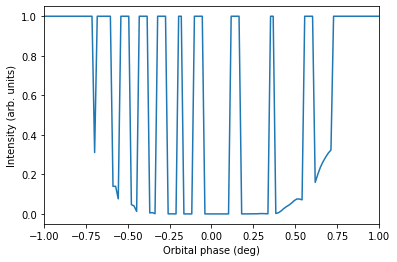

In [15]:
plt.plot(phi_orb - 90*u.deg, eclipse_profile)
plt.xlabel("Orbital phase ({0})".format(phi_orb.unit))
plt.ylabel("Intensity (arb. units)")
plt.xlim(-1,1)
plt.show()